## Advanced Lane Lines

The goal of this project is :
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position in a video.

and the steps of this project are the following:
* 1)Cabera Calibration: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. Apply a distortion correction to raw images.
* 2)Threshold image: Use color transforms, gradients, etc., to create a thresholded binary image.
* 3)Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline
#%matplotlib qt4 

## Camera Calibration

In [2]:
# read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg' )

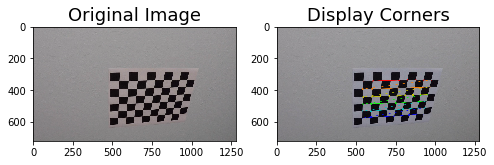

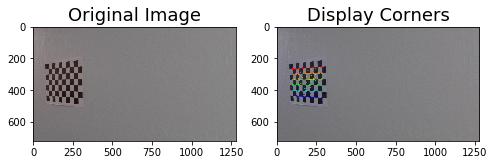

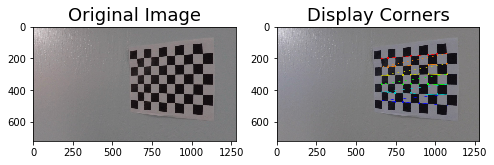

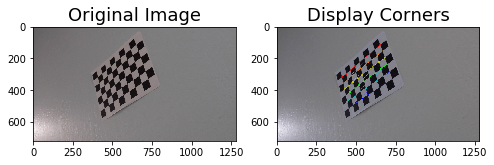

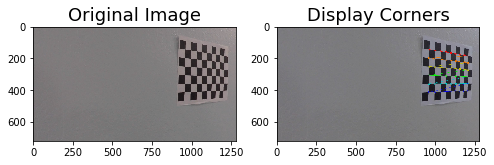

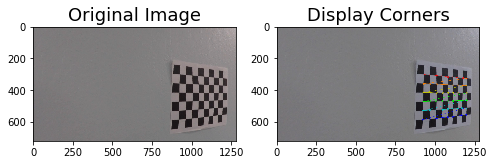

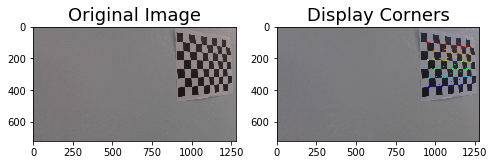

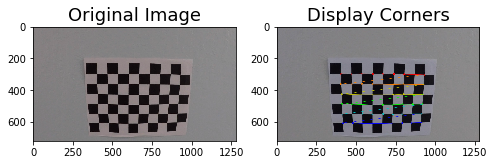

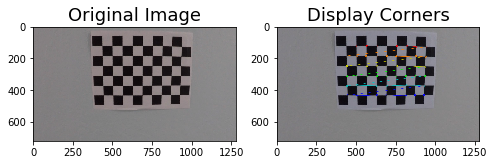

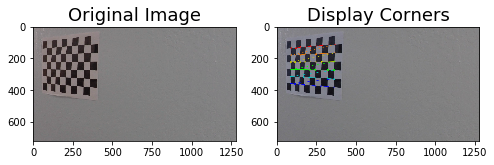

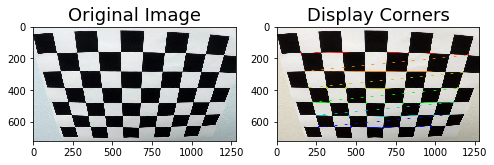

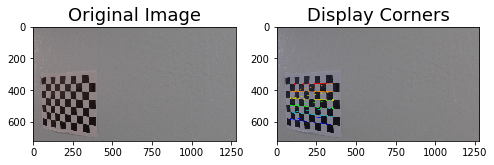

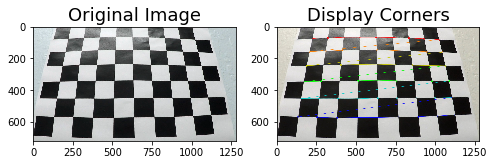

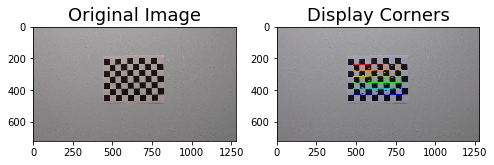

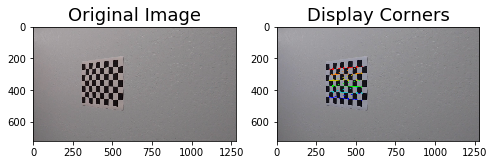

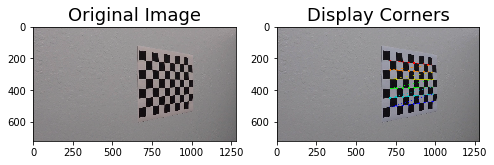

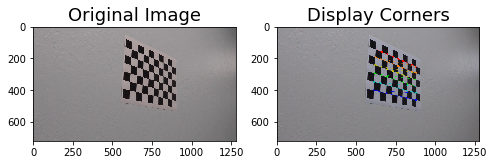

In [3]:
# prepare object points
nx=9
ny=6
#arrays to store object points and image points from all images
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#prepare object points like (0,0,0)  (1,0,0), (2,0,0),... (7,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2]= np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x,y coordinates

for fname in images:
    #read image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    #print(ret)
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Display Corners', fontsize=18)

In [393]:
def cal_undistort(img, show=True):
    #img = mpimg.imread(img)
    # img.shape[0:2] for color image
    # gray.shape[::-1] for grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        #ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.imshow(img)
        ax1.set_title('Original', fontsize=50)
        #ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.imshow(undist)
        ax2.set_title('Undistorted', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return undist



## Threshold image

In [394]:
def cal_threshold_base(img,s_thresh=(90, 255), sx_thresh=(20, 180), show=True):
    #img=cal_undistort(img,show=False)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    color_binary = np.zeros_like(scaled_sobel)
    color_binary[(sxbinary == 1) | (s_binary == 1) ] = 1
    color_binary = np.dstack(( color_binary,color_binary,color_binary)).astype(np.float32)

    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Undistorted', fontsize=50)
        ax2.imshow(color_binary,cmap='gray')
        ax2.set_title('Thresholded ', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return color_binary

## Perspective Transform ( birds-eye view )

In [ ]:
#%matplotlib qt
# Read in an image
#img = mpimg.imread('test_images/straight_lines1.jpg')
#plt.imshow(img)
%matplotlib inline

In [387]:
def cal_perspective(undist, show=True): 
    #undist = cal_threshold_base(img,s_thresh=(170, 255), sx_thresh=(20, 80),show = False)
    
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform( dst,src)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    if show:
        color=(0,123,255)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        #cv2.line(undist, (490, 482), (810, 482),color, 5)#
        #cv2.line(undist, (490, 482), (40, 720), color,5)#
        #cv2.line(undist, (810, 482), (1250, 720), color,5)#
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Thresholded', fontsize=50)
        
        #offset=200
        #cv2.line(warped, (0+offset, 0), (0+offset,1280-offset), color,5)#
        #cv2.line(warped, (1280-offset,0), ( 1280-offset, 1280-offset), color,5)#
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Warped', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped, M, Minv

## Finding Lanes

In [131]:
def cal_histogram_peaks(img):
    warpP, M ,Minv= cal_perspective(img,show=False)    
    histogram = np.sum(warpP[int(warpP.shape[0]/2):,:], axis=0)
      
    f, (ax1) = plt.subplots(1, 1, figsize=(20, 5))
    f.tight_layout()
    ax1.plot(histogram)
    ax1.set_title('Binary Histogram', fontsize=20)


In [ ]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    #a=cal_perspective_test(image)
    cal_histogram_peaks(image)

In [388]:
def cal_slidingWindow(binary_warped,show=True):
    #img='test_images/straight_lines1.jpg'
    # Assuming you have created a warped binary image called "binary_warped"
    #warped, M, Minv = cal_perspective(img,show=False)

    #binary_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8') # if using CV2.___2gray

    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #print(win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if show:
        f, (ax1,ax2 ) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(binary_warped)
        ax1.set_title('Warped', fontsize=50)
    
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')
        
        ax2.imshow(out_img)
        ax2.set_title('Windowed', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]    
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    return left_curverad, right_curverad,ploty, left_fitx , right_fitx, center

In [389]:
def cal_fill_lines(image, undist, warped, ploty, left_fitx , right_fitx, Minv, left_curverad, right_curverad, center,show=True):
    # Create an image to draw the lines on
    #warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    if center < 640:
        text=( 'Vehicle is {:.2f}m left of center'.format(center*3.7/700))
    else:
        text=( 'Vehicle is {:.2f}m left of center'.format(center*3.7/700))
    text_curve = ( 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)))
    font = cv2.FONT_HERSHEY_DUPLEX
    if show:
        f, (ax1 ) = plt.subplots(1, 1, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(result)
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(0, 720)
        ax1.invert_yaxis()
        ax1.set_title('Result Image', fontsize=30)
        if center < 640:
            ax1.text(100, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                    style='italic', color='white', fontsize=20)
        else:
            ax1.text(100, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                     style='italic', color='white', fontsize=20)
        ax1.text(100, 155, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
                 style='italic', color='white', fontsize=20)
    cv2.putText(result, text, (40,70), font, 1, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(result, text_curve, (40,120), font, 1, (255,255,255), 1, cv2.LINE_AA)
    
    return result

## Sliding Window Search

In [ ]:

# Read in a thresholded image
#warped = mpimg.imread('test_images/warped-example.jpg')


img='test_images/straight_lines1.jpg'
# Assuming you have created a warped binary image called "binary_warped"
warp, M = cal_perspective(img,show=False)

warped = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)



# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 

    #If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


## Pipeline

In [395]:
def pipeline(img):
    s=True
    undist_img = cal_undistort(img, show=s)
    threshold_img = cal_threshold_base(undist_img,s_thresh=(170, 255), sx_thresh=(20, 80), show=s)
    warped_3, M, Minv = cal_perspective(threshold_img , show=s)
    warped = cv2.cvtColor(warped_3, cv2.COLOR_BGR2GRAY)
    left_curverad, right_curverad,ploty, left_fitx , right_fitx, center = cal_slidingWindow(warped,show=s)
    result = cal_fill_lines(img, undist_img, warped, ploty, left_fitx , right_fitx,Minv,left_curverad, right_curverad, center,show=s)


    return result

"\nf, (ax1 ) = plt.subplots(1, 1, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(result)\nax1.set_title('Result Image', fontsize=50)\n\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

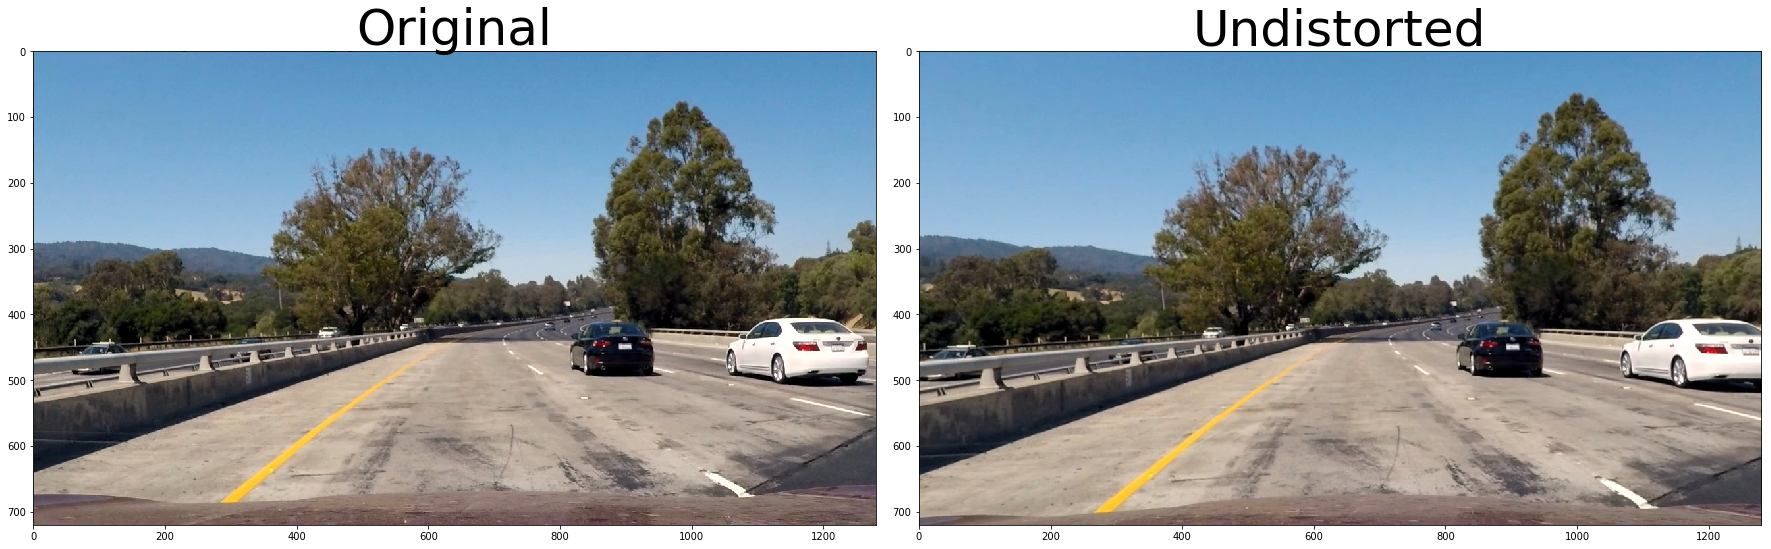

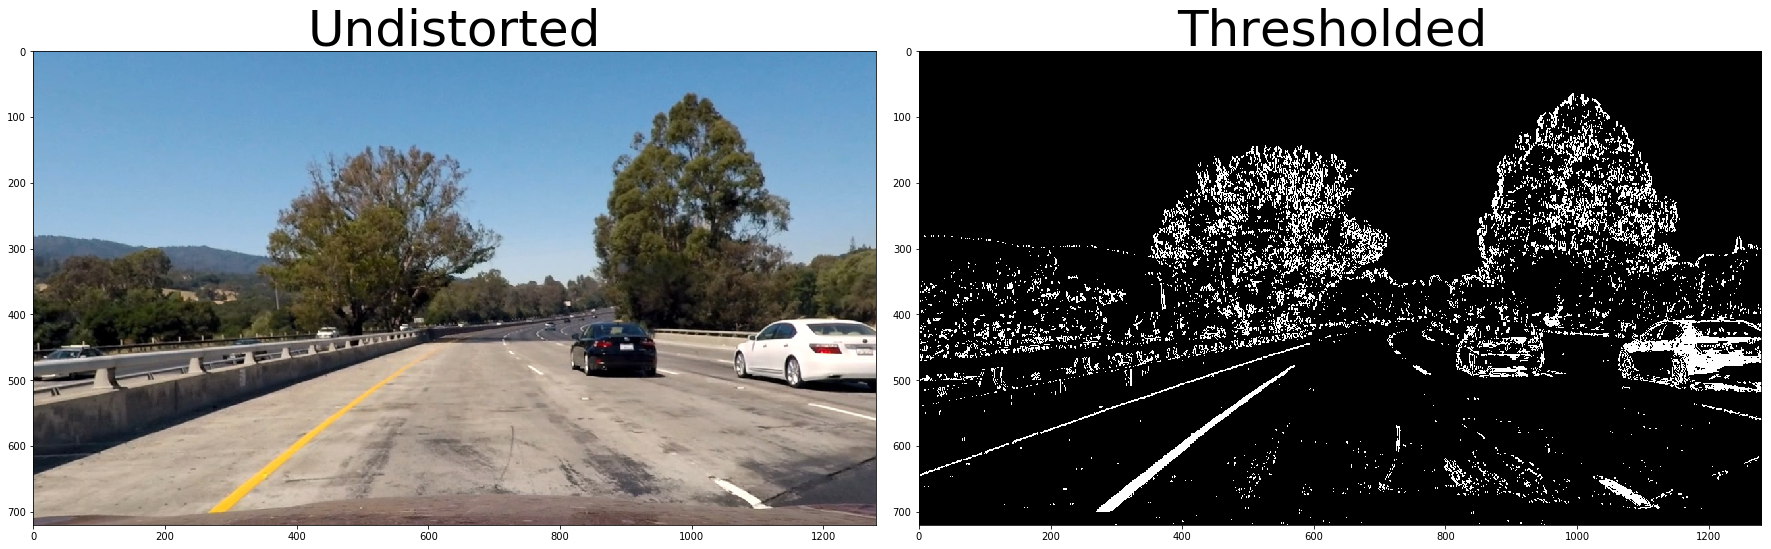

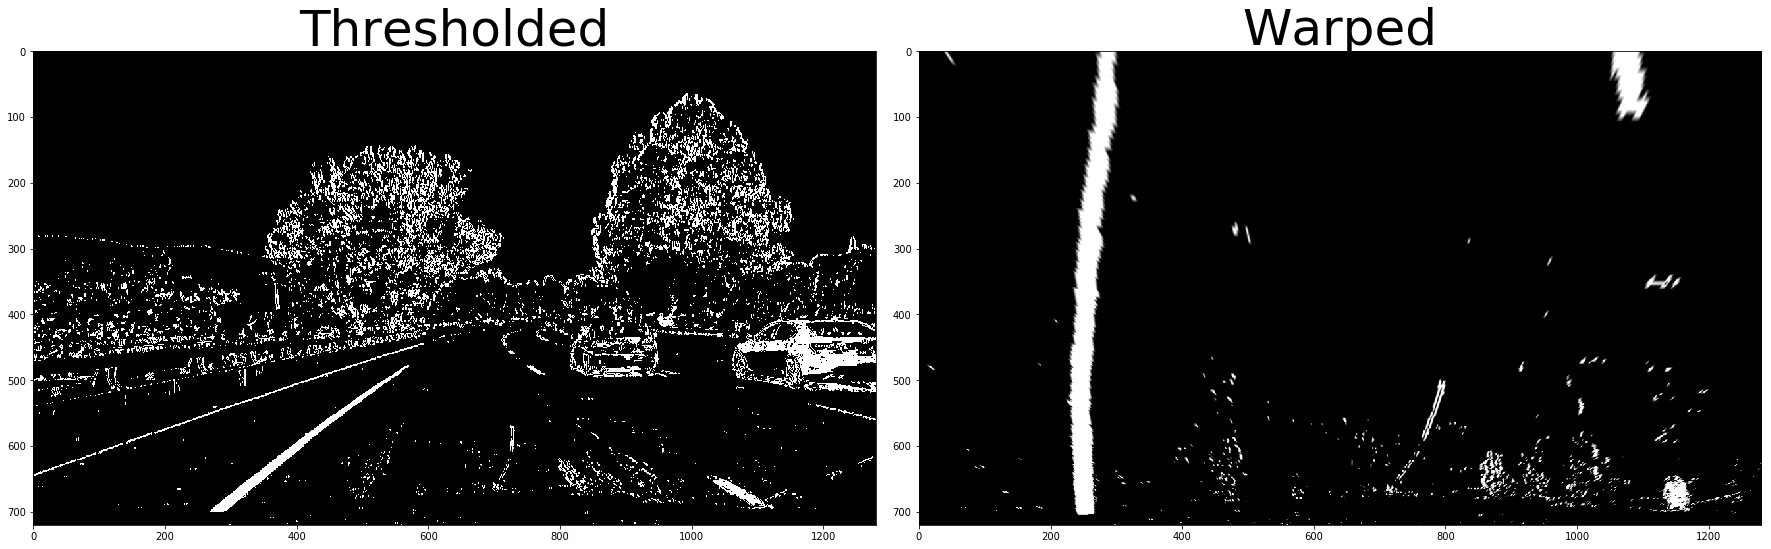

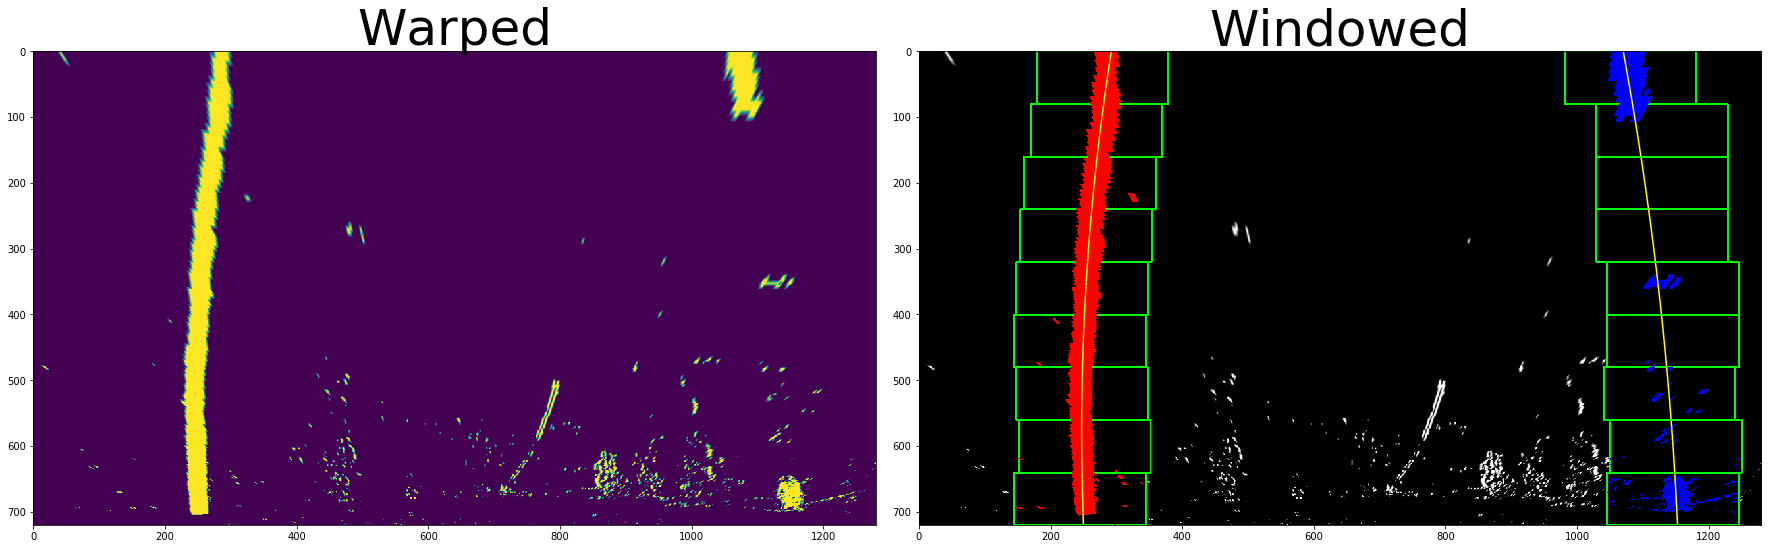

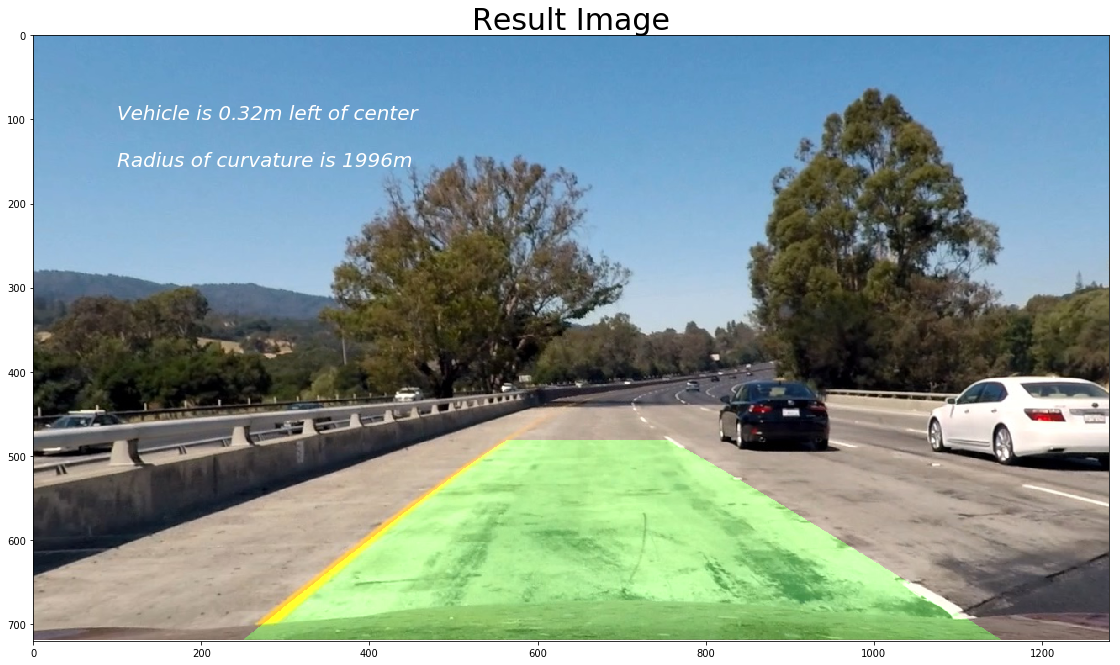

In [396]:
image = 'test_images/test1.jpg'
img =  mpimg.imread(image)
result = pipeline(img)
'''
f, (ax1 ) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Result Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''

In [ ]:
images = glob.glob('test_images/test*.jpg')
print(images)
for image in images:
    result=pipeline(image)

    f, (ax1 ) = plt.subplots(1, 1, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(result)
    ax1.set_title('Result Image', fontsize=50)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
  

In [373]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


test_input = 'project_video.mp4'
test_output = 'project_video_processed.mp4'

clip = VideoFileClip(test_input)
test_clip = clip.fl_image(pipeline)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [35:17<00:01,  1.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 



In [375]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

## Tracking

In [192]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
